In [151]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cu124'

In [152]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [153]:
#formula de regresion
weight=0.7
bias=0.3
start=0
end=1
step=0.02
X=torch.arange(start, end, step). unsqueeze(dim=1)
y= weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [154]:
#split data
train_split= int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [155]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="predictions")

  plt.legend(prop={"size": 14});



In [156]:
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self, x: torch.Tensor)  -> torch.Tensor:
     return self.linear_layer(x)


torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [157]:
X_train[:5], y_train[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

In [158]:
#check device model
next(model_1.parameters()).device

device(type='cpu')

In [159]:
#set the model to use gpu
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [160]:
#loss function
loss_fn = nn.L1Loss()
#set up optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [161]:
torch.manual_seed(42)

epochs = 100

#put data on the same device
X_train=X_train.to(device)
y_train=y_train.to(device)
X_test=X_test.to(device)
y_test=y_test.to(device)

for epoch in range(epochs):
  model_1.train()
  #forward pass
  y_pred = model_1(X_train)
  #calculate the loss
  loss = loss_fn(y_pred, y_train)
  #optimizer zero grad
  optimizer.zero_grad()
  #loss backward
  loss.backward()
  #optimizer step
  optimizer.step()
  ### testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)
  if epoch % 10 == 0:
    print(f"epoch: {epoch} | loss:{loss} | test loss:{test_loss}")
    print(model_1.state_dict())

epoch: 0 | loss:0.5551779866218567 | test loss:0.5739762187004089
OrderedDict([('linear_layer.weight', tensor([[0.7606]], device='cuda:0')), ('linear_layer.bias', tensor([0.8200], device='cuda:0'))])
epoch: 10 | loss:0.439968079328537 | test loss:0.4392664134502411
OrderedDict([('linear_layer.weight', tensor([[0.7216]], device='cuda:0')), ('linear_layer.bias', tensor([0.7200], device='cuda:0'))])
epoch: 20 | loss:0.3247582018375397 | test loss:0.30455657839775085
OrderedDict([('linear_layer.weight', tensor([[0.6826]], device='cuda:0')), ('linear_layer.bias', tensor([0.6200], device='cuda:0'))])
epoch: 30 | loss:0.20954833924770355 | test loss:0.16984669864177704
OrderedDict([('linear_layer.weight', tensor([[0.6436]], device='cuda:0')), ('linear_layer.bias', tensor([0.5200], device='cuda:0'))])
epoch: 40 | loss:0.09433845430612564 | test loss:0.03513690456748009
OrderedDict([('linear_layer.weight', tensor([[0.6046]], device='cuda:0')), ('linear_layer.bias', tensor([0.4200], device='cuda

In [162]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6691]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3130], device='cuda:0'))])

In [163]:
model_1.eval()
#make predictions
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8483],
        [0.8617],
        [0.8750],
        [0.8884],
        [0.9018],
        [0.9152],
        [0.9286],
        [0.9420],
        [0.9553],
        [0.9687]], device='cuda:0')

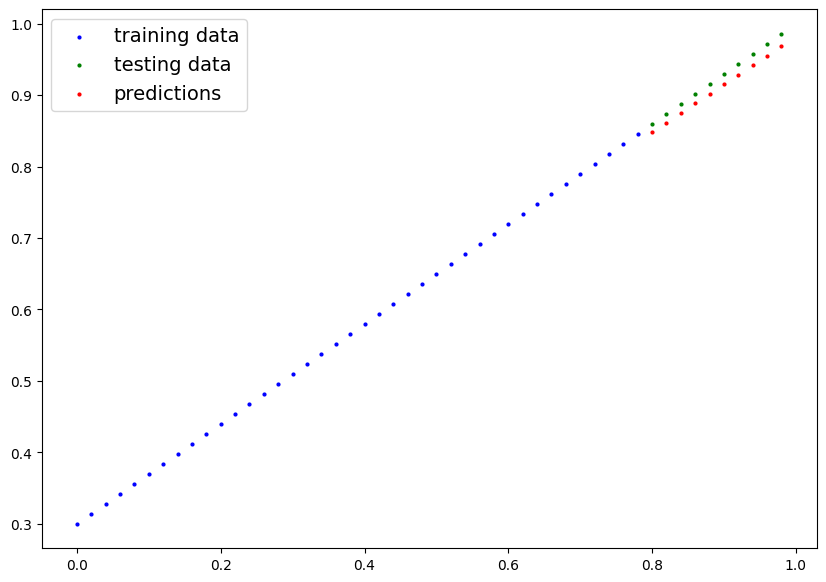

In [164]:
#check visually
plot_predictions(predictions=y_preds.cpu())

In [166]:
#save model
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME= "dummy_linear_model_1.pth"
MODEL_SAVE_PATH= MODEL_PATH / MODEL_NAME

print(f"saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)



saving model to models/dummy_linear_model_1.pth


In [167]:
#load model
loaded_model_1= LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_1.to(device)

<ipython-input-167-c431c1552ca9>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))


LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)